In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import random
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import TreebankWordTokenizer
from collections import defaultdict
import nltk
import string
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to /home/biy011/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/biy011/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_orig = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin1')
test_orig = pd.read_csv('Corona_NLP_test.csv',encoding = 'latin1')

# Preprocess start here!

In [3]:
train_orig=train_orig[['OriginalTweet','Sentiment']]
test_orig=test_orig[['OriginalTweet','Sentiment']]

In [4]:
#pd.isnull(train_orig).sum()
#pd.isnull(test_orig).sum()

In [5]:
train_orig = train_orig.dropna()
test_orig = test_orig.dropna()

In [6]:
def remove_urls(input_text):
    input_text=str(input_text)
    result=re.sub(r'http.?://[^\s]+[\s]?', '', input_text)
    return result

def remove_nonASCII(string_):
    printable = set(string.printable)
    punctuation = set(string.punctuation)
    #res=''.join(filter(lambda x: x not in printable, string_))
    r = ''.join([c for c in string_ if (c in printable and c not in punctuation)])
    return r

def remove_speChar(string):
    if '\r' in string:
        string=string.replace('\r', ' ')
    if  '\n' in string:
        string=string.replace('\n', ' ')
    return string

In [7]:
train_orig['NewTweet']=train_orig.apply(lambda row: remove_urls(row['OriginalTweet']), axis=1)
test_orig['NewTweet']=test_orig.apply(lambda row: remove_urls(row['OriginalTweet']), axis=1)

In [8]:
train_orig.head(10)

,OriginalTweet,Sentiment,NewTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,@MeNyrbie @Phil_Gahan @Chrisitv and and
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia: Woolworths to give elde...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,"Me, ready to go at supermarket during the #COV..."
5,As news of the regionÂs first confirmed COVID...,Positive,As news of the regionÂs first confirmed COVID...
6,Cashier at grocery store was sharing his insig...,Positive,Cashier at grocery store was sharing his insig...
7,Was at the supermarket today. Didn't buy toile...,Neutral,Was at the supermarket today. Didn't buy toile...
8,Due to COVID-19 our retail store and classroom...,Positive,Due to COVID-19 our retail store and classroom...
9,"For corona prevention,we should stop to buy th...",Negative,"For corona prevention,we should stop to buy th..."


In [9]:
train_orig['NewTweet']=train_orig.apply(lambda row: remove_nonASCII(row['NewTweet']), axis=1)
test_orig['NewTweet']=test_orig.apply(lambda row: remove_nonASCII(row['NewTweet']), axis=1)

In [10]:
train_orig.head()

,OriginalTweet,Sentiment,NewTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,MeNyrbie PhilGahan Chrisitv and and
1,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the COVID...


In [11]:
train_orig['NewTweet'] = train_orig['NewTweet'].str.lower()
train_orig['NewTweet']=train_orig.apply(lambda row: remove_speChar(row['NewTweet']), axis=1)
train_ls=train_orig['NewTweet'].tolist()
train = train_orig

test_orig['NewTweet'] = test_orig['NewTweet'].str.lower()
test_orig['NewTweet']=test_orig.apply(lambda row: remove_speChar(row['NewTweet']), axis=1)
test_ls=test_orig['NewTweet'].tolist()
test = test_orig

# change 5 categories to 3; change "netural":0, "positive":1,"negative":2

In [12]:
train['Sentiment'].unique()
#change five categories to three 
train_df = train
test_df = test

In [13]:
def change_sen(sentiment):
    if sentiment == "Extremely Positive":
        return 'positive'
    elif sentiment == "Extremely Negative":
        return 'negative'
    elif sentiment == "Positive":
        return 'positive'
    elif sentiment == "Negative":
        return 'negative'
    else:
        return 'netural'

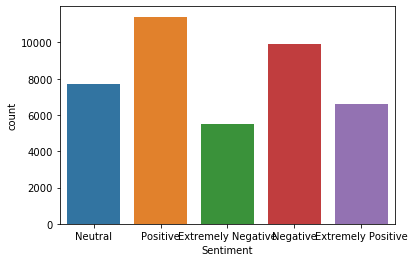

In [14]:
sns.countplot(train['Sentiment'])

In [15]:
train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_sen(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_sen(x))

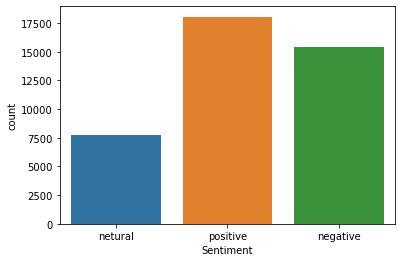

In [16]:
sns.countplot(train_df['Sentiment'])

In [17]:
label = {"netural":0, "positive":1,"negative":2}
train_df['Sentiment'] = train_df['Sentiment'].map(label)
test_df['Sentiment']  = test_df['Sentiment'].map(label)

# tokenization & word count & vocab_to_int

In [18]:
# count frequency of words in counts; 
#create word dict:word_to_int based on counts 
def word_dict(ls, type_):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    tokenizer = TreebankWordTokenizer()
    for d in ls:
        d = tokenizer.tokenize(d)
        #d = [token for token in d if token not in stop_words]
        for w in d:
            wordCount[w] += 1
    #count is counting the word frequency and sort from most frequent to least
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    words_list = [x[1] for x in counts]
    words = set(words_list)
    vocab_to_int={w:i+1 for i,(c,w) in enumerate(counts)}
    if type_ =='v':
        return vocab_to_int
    else:
        return counts

In [19]:
train_c = word_dict(train_df['NewTweet'], 'c')
train_vocab_to_int = word_dict(train_df['NewTweet'], 'v')

test_c = word_dict(test_df['NewTweet'], 'c')
test_vocab_to_int = word_dict(test_df['NewTweet'], 'v')

In [20]:
#tweet int: list contains list of sentence in which words convert to numerical values
def w_to_num(vocab_to_int,ls):
    tweet_int = []
    for review in ls:
        cur_ls=[]
        for word in review.split():
            if word not in vocab_to_int.keys():
                cur_ls.append(0)
            else:
                cur_ls.append(vocab_to_int[word])
        tweet_int.append(cur_ls)
    return tweet_int

In [21]:
train_int = w_to_num(train_vocab_to_int,train_ls)

test_int = w_to_num(test_vocab_to_int,test_ls)

tweet_Int<- x_train; sentiment <- train_df[..]

## Plot Tweet length distribution

In [22]:
def plot_tweet(ls,string):
    reviews_len = [len(x) for x in ls]
    pd.Series(reviews_len).hist()
    plt.title(string + ' tweet length distribution: word length in tweet VS frequency ')
    plt.xlabel('legnth of word in each tweet')
    plt.ylabel('frequeccy')
    plt.show()
    print(pd.Series(reviews_len).describe())

In [23]:
print(len(train_int))

41157


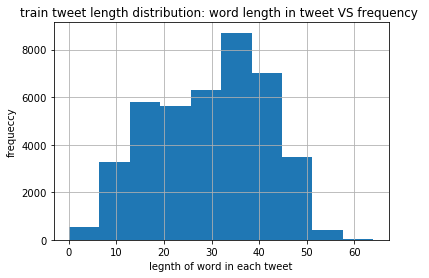

count    41157.000000
mean        29.613674
std         11.704519
min          0.000000
25%         20.000000
50%         31.000000
75%         39.000000
max         64.000000
dtype: float64


In [24]:
plot_tweet(train_int,'train')

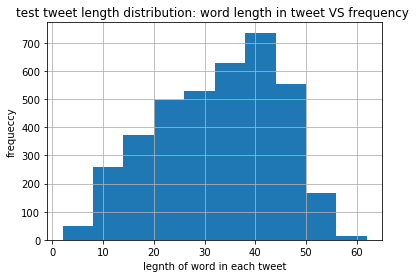

count    3798.000000
mean       32.086888
std        11.840029
min         2.000000
25%        23.000000
50%        33.000000
75%        42.000000
max        62.000000
dtype: float64


In [25]:
plot_tweet(test_int,'test')

# Padding / Truncating data

In [26]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [27]:
#self define seq_length as 31(same as median, close to mean) 
THRESHOLD = 31
feature_train = pad_features(train_int,THRESHOLD)
#print(feature_ls)
feature_test = pad_features(test_int,THRESHOLD)
#we set the THRESHOLD so that all tweet length have the same length
#for tweet shorter than length set them to zero;
#for those longer: cut them to threshold

In [ ]:
df.to_csv(index=False)
'name,mask,weapon\nRaphael,red,sai\nDonatello,purple,bo staff\n'

# split train & validation

In [36]:
x = feature_test
y = test_df['Sentiment']

In [39]:
df = pd.DataFrame (x)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,0,0,0,0,0,0,0,0,0,...,2953,38,1187,9888,8483,41,10927,384,20,22
1,0,0,85,12,985,268,119,181,17,4647,...,5,7333,40,71,8,566,13,1409,22,46
2,0,0,0,0,0,0,0,0,0,0,...,71,15,47,439,720,4,2180,614,43,8
3,42,67,1900,2160,460,41,1742,384,20,22,...,1586,680,8,1499,30,7,11632,6391,1113,2480
4,0,0,0,0,0,0,307,10371,8,1713,...,584,443,3094,1,223,90,67,22,53,55


In [28]:
feature_train

array([[    0,     0,     0, ..., 15893,     3,     3],
       [  516,   907,     2, ..., 14227,  3376,   193],
       [    0,     0,     0, ...,   162,     8,   137],
       ...,
       [    0,     0,     0, ...,    81,    66,    42],
       [    0,     0,     0, ...,     7,     8,     7],
       [28460,   192, 37855, ..., 12369,   239, 20529]])

In [29]:
#split train and validation data (80,20)
X_train, X_val, y_train, y_val = train_test_split(feature_train, train_df['Sentiment'].to_numpy(), test_size=0.2, random_state=42)
X_test, y_test = feature_test, test_df['Sentiment']
